In [99]:
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os
import scipy.misc as s
import pandas as pd
import random

The labels of each face image is embedded in the file name, formated like [age] _ [gender] _ [race] _ [date&time].jpg

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

https://susanqq.github.io/UTKFace/

In [9]:
files = os.listdir("data/crop_part1/")

In [31]:
image_file = Image.open("data/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg") # open colour image

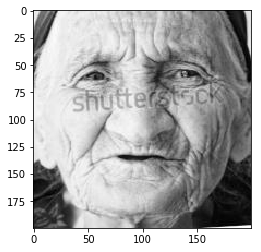

In [30]:
plt.imshow(np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140]), cmap='gray')

In [100]:
random.shuffle(files) #randomizing the files to sample from it (this is just to save time)

In [103]:
male_faces = pd.DataFrame([])
female_faces = pd.DataFrame([])
m = 0
fe = 0
for f in files:
    if f.split('_')[1] == "0" and m<200: #male
        m += 1
        image_file = Image.open("data/crop_part1/" + f)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        male_faces = male_faces.append(face)
    if f.split('_')[1] == "1" and fe<200: #female
        fe += 1
        image_file = Image.open("data/crop_part1/" + f)
        img = np.dot(np.array(image_file)[:,:,:3], [0.2989, 0.5870, 0.1140])/255 #convert to gray scale
        face = pd.Series(img.flatten(), name=f)
        female_faces = female_faces.append(face)

In [104]:
male_faces.shape, female_faces.shape

((200, 40000), (200, 40000))

# PCA

In [113]:
from sklearn.decomposition import PCA

In [114]:
faces_pcam = PCA(n_components=20)
faces_pcam.fit(male_faces)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [115]:
faces_pcaf = PCA(n_components=20)
faces_pcaf.fit(female_faces)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [116]:
componentsm = faces_pcam.transform(male_faces)
projectedm = faces_pcam.inverse_transform(componentsm) #Reconstruction of the original image

In [117]:
projectedm.shape

(200, 40000)

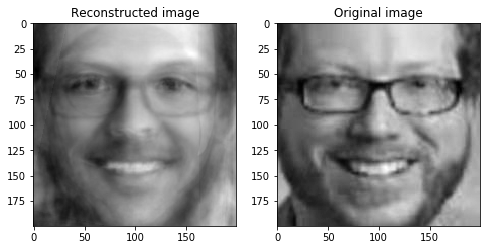

Reconstruction error is :  14.729297520422604


In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(projectedm[2].reshape((200,200)), cmap='gray')
axes[0].set_title("Reconstructed image")
axes[1].imshow(np.array(male_faces)[2].reshape((200,200)), cmap='gray')
axes[1].set_title("Original image")
plt.show()
print("Reconstruction error is : ", np.sqrt(np.sum(np.square(np.array(male_faces)[2].reshape((200,200)) - projectedm[2].reshape((200,200))))))

In [119]:
#Computing reconstruction error 
def RE_error(df1, df2):
    arr1 = np.array(df1)
    arr2 = np.array(df2)
    res = []
    for sample in range(arr2.shape[0]):
        res.append(np.sqrt(np.sum(np.square(arr1[sample] - arr2[sample]))))
    return np.mean(res)

### Bias between males and females in PCA 

In [126]:
re_male = []
re_female = []
dim = [d for d in range(2,30)]
for d in dim:
    #computing RE for men with dimensionnality reduction d
    faces_pcam = PCA(n_components=d)
    faces_pcam.fit(male_faces)
    componentsm = faces_pcam.transform(male_faces)
    projectedm = faces_pcam.inverse_transform(componentsm)
    re_male.append(RE_error(male_faces, projectedm))
    #-------------------------
    #computing RE for women with dimensionnality reduction d
    faces_pcaf = PCA(n_components=d)
    faces_pcaf.fit(female_faces)
    componentsf = faces_pcaf.transform(female_faces)
    projectedf = faces_pcaf.inverse_transform(componentsf)
    re_female.append(RE_error(female_faces, projectedf))

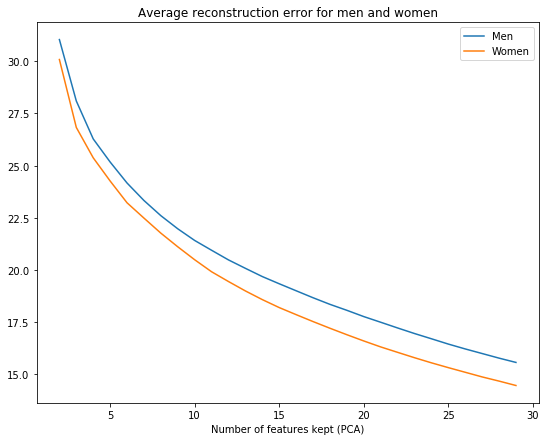

In [127]:
plt.figure(figsize=(9, 7))
plt.plot(dim, re_male, label="Men")
plt.plot(dim, re_female, label="Women")
plt.legend()
plt.title("Average reconstruction error for men and women")
plt.xlabel("Number of features kept (PCA)")
plt.show()